<a href="https://colab.research.google.com/github/inesdarosa/visualizaciones_analisis/blob/main/final_dbscan_mediana_C7_da_rosa_cranwell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# librerias generales para trabajar con dataframes, arrays, modificar datos tipo fecha y realizar gráficos

import pandas as pd
from datetime import datetime
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

# librerias para generar grupos de training y test, cálculo de métricas y escalar datos

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# libreria para realizar análisis multivariado DBSCAN con el fin de identificar outliers

from sklearn.cluster import DBSCAN

# librerias para la generación de redes neuronales

from keras import models, layers, optimizers, regularizers
from keras.layers import Dense, Activation, Dropout

In [62]:
# Se accesa a los datos de las variables explicatorias y el contenido de C7

C7_2022 = pd.read_csv('/content/drive/MyDrive/ejercicios_proyectos/ancap/DATACHALLENGE 2022/Desafio_Contenido_C7_Total_11-2017_09-2021.csv')
var_ind_2022 = pd.read_csv('/content/drive/MyDrive/ejercicios_proyectos/ancap/DATACHALLENGE 2022/Desafio_VariablesControl_DCH2022.csv', sep=';')


In [ ]:
# Se eliminan posibles datos no válidos, se cambia dato a tipo fecha

C7_2022.Contenido_C7_Total = pd.to_numeric(C7_2022.Contenido_C7_Total, errors='coerce')
var_ind_2022['TimeStamp'] = pd.to_datetime(var_ind_2022['TimeStamp'])
print(C7_2022.head())
print(var_ind_2022.head())

In [64]:
# Se genera una variable que junte la fecha y la hora

C7_2022['Fecha_Hora'] = pd.to_datetime(C7_2022['Fecha'] + ' ' + C7_2022['Hora'])
print(C7_2022.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               1049 non-null   object        
 1   Hora                1049 non-null   object        
 2   Contenido_C7_Total  1048 non-null   float64       
 3   archivo             1049 non-null   object        
 4   Fecha_Hora          1049 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 41.1+ KB
None


In [65]:
# Se eliminan posibles nan en las matrices

C7_2022.dropna(inplace=True)
var_ind_2022.dropna(inplace=True)

En la siguiente celda se genera un dataframe de matrices, cada matriz tiene las 33 variables explicatorias, cada una por columna. Cada columna tiene los valores de las 6 horas anteriores considierando la Fecha-hora de la variable dependiente, Contenido de C7. Fueron elegidas 6 horas empíricamente, luego de haber probado diferentes períodos.

La imagen muestra un esquema de cómo se genera la lista de matrices mencionada. En la imágen se muestra 120 minutos en lugar de 360 minutos (horas).

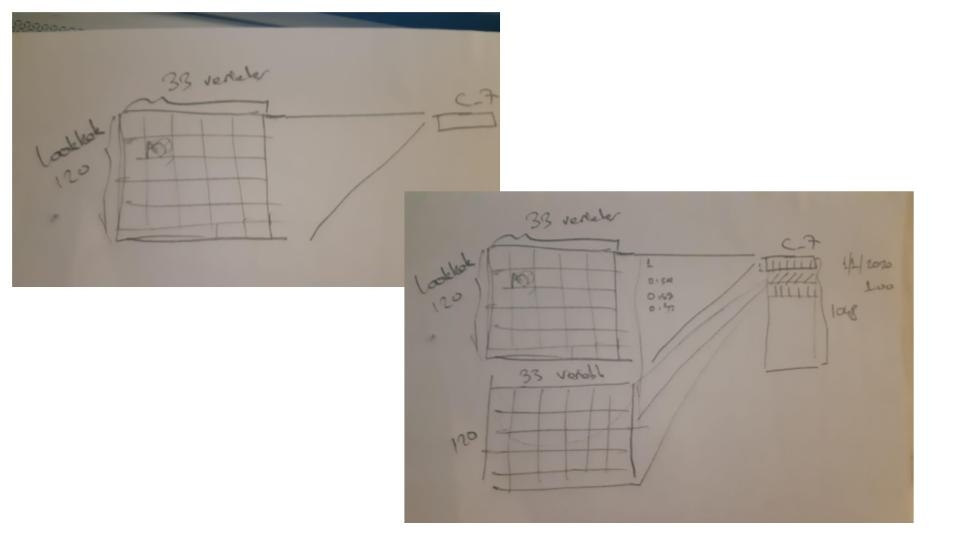

In [66]:
# Aqui se genera un dataframe de matrices, cada matriz tiene las 33 variables explicatorias, cada una por columna. Cada columan tiene los valores de las 6 horas
# anteriores considierando la Fecha-hora de la variable dependiente, Contenido de C7. 
# En nuestro caso este proceso demora entre 7-8 minutos.

var_ind_2022['indice'] = np.arange(var_ind_2022.shape[0])

dfXinterval_clean = []

for i in range(len(C7_2022)):
    mask = var_ind_2022['TimeStamp'] == C7_2022.iloc[i,4]
    ind = var_ind_2022.loc[mask]['indice']
    matriz_vars_tiempo = pd.DataFrame()
    for j in range(360):
        #print("indice>" +str(ind))
        #print("j>"+str(j))
        fila = var_ind_2022.iloc[ind-j,1:-1]
        #print(fila)
        matriz_vars_tiempo = matriz_vars_tiempo.append(fila, ignore_index = True)
    dfXinterval_clean.append(matriz_vars_tiempo)

In [67]:
# Aquí se genera una lista, esa lista va a contener la mediana de cada columna por cada fecha-hora correspondiente al contenido de C7. Por lo tanto, tenemos
# por cada dato de Contenido de C7 un valor correspondiente a cada columna (variable explicatoria). Ese valor corresponde a la mediana de los últimos 360 minutos
# de cadad variable explicatoria.

list_indep = []

for i in range(len(C7_2022)):
    mediana = dfXinterval_clean[i].describe().iloc[5,].values
    list_indep.append(mediana)


In [68]:
# Esta es una muestra de un elemento de la lista, cada valor es la mediana correspondiente a cada columna en una fecha-hora correspondiente al Contenido de C7. 

list_indep[0:1]

[array([  0.82295 ,   0.82834 ,   0.85039 ,  99.53842 ,  74.10052 ,
         39.09554 , 146.65527 , 133.9634  , 133.9607  , 142.35582 ,
         70.538655,  70.000155,  35.00312 ,  21.00262 ,   2.97143 ,
         40.01533 ,   7.86349 ,   0.72959 ,   4.51    ,  17.69    ,
          0.75569 ,   0.67096 ,  70.001465,  21.74582 , 452.574435,
         19.29203 ,  20.500545, 202.68887 ,  26.80579 ,  10.900415,
         20.87912 , 140.97337 ,  42.186225])]

In [69]:
# Se transforma la lista en dataframe

indep = pd.DataFrame(list_indep)
indep = indep.rename(columns={0: 'tdc_phd.pi_21030', 1: 'tdc_phd.pic_21034', 2: 'tdc_phd.pi_21035', 3: 'tdc_phd.ti_21046', 4: 'tdc_phd.tic_21047', 5: 'tdc_phd.ti_21048',
             6: 'tdc_phd.ti_21050', 7: 'tdc_phd.ti_21049', 8: 'tdc_phd.tic_21051', 9: 'tdc_phd.ti_21052', 10: 'tdc_phd.li_21018', 11: 'tdc_phd.lic_21022',
             12: 'tdc_phd.fic_21018', 13: 'tdc_phd.fic_24002', 14: 'tdc_phd.fi_21019', 15: 'tdc_phd.fic_22001', 16: 'tdc_phd.fi_21020', 17: 'STMS_DI_21004',
             18: 'STMS_LAB_PM_2209-F', 19: 'STMS_PM_2104F', 20: 'STMS_DI_22001', 21: 'STMS_DI_FIC_24002', 22: 'TDC_PHD.FIC_21004', 23: 'TDC_PHD.TI_21004',
             24: 'TDC_PHD.FI_21008', 25: 'TDC_PHD.TI_21029', 26: 'TDC_PHD.PIC_22059', 27: 'TDC_PHD.FI_21012', 28: 'TDC_PHD.TI_21036', 29: 'TDC_PHD.PIC_21026',
             30: 'TDC_PHD.TI_21054', 31: 'TDC_PHD.TI_22001', 32: 'TDC_PHD.TI_24001'})

In [70]:
# Se genera la tabla con todos los datos incluyendo el Contenido de C7.

indep_C7 = pd.concat([indep, C7_2022['Contenido_C7_Total']], axis=1)
indep_C7.dropna(inplace=True)
indep_C7

,tdc_phd.pi_21030,tdc_phd.pic_21034,tdc_phd.pi_21035,tdc_phd.ti_21046,tdc_phd.tic_21047,tdc_phd.ti_21048,tdc_phd.ti_21050,tdc_phd.ti_21049,tdc_phd.tic_21051,tdc_phd.ti_21052,...,TDC_PHD.FI_21008,TDC_PHD.TI_21029,TDC_PHD.PIC_22059,TDC_PHD.FI_21012,TDC_PHD.TI_21036,TDC_PHD.PIC_21026,TDC_PHD.TI_21054,TDC_PHD.TI_22001,TDC_PHD.TI_24001,Contenido_C7_Total
0,0.822950,0.828340,0.850390,99.538420,74.100520,39.095540,146.655270,133.963400,133.960700,142.35582,...,452.574435,19.292030,20.500545,202.688870,26.805790,10.900415,20.879120,140.973370,42.186225,1.58
1,0.818255,0.828735,0.837565,102.348440,72.366000,31.766700,151.701355,134.497830,134.492235,145.12355,...,453.096310,20.234720,20.297700,175.962550,23.155510,10.845210,23.945960,143.887500,35.289840,0.87
2,0.821700,0.833630,0.851885,104.282020,75.835110,34.209830,150.374030,133.890080,133.893775,146.55833,...,430.011735,18.199170,20.497570,215.746375,33.092155,9.766465,18.967735,144.819105,37.779400,1.29
3,0.831545,0.845390,0.856660,103.022605,77.232510,28.429250,151.449585,134.733420,134.735405,147.79601,...,514.515205,17.453200,20.499545,285.436690,39.387850,9.381635,18.674365,146.075840,32.042325,1.90
4,0.817085,0.837985,0.847255,100.207360,77.798725,30.769290,148.100945,135.010385,134.990040,145.55636,...,451.301755,15.510420,20.498910,412.012370,46.110985,10.543075,16.638055,143.695970,32.648460,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0.765955,0.829830,0.883575,93.394680,72.895990,39.241700,143.239405,129.723530,129.720350,140.38118,...,345.466630,18.224015,20.498600,280.821130,43.632125,10.351960,13.893960,138.741250,41.335090,1.64
1044,0.787395,0.828685,0.970645,93.684680,75.353260,46.744565,139.546805,130.070815,130.071650,137.57069,...,372.771105,21.634440,20.499570,367.380735,46.150395,10.899900,16.457490,136.351570,48.416965,0.77
1045,0.811500,0.828180,0.991355,92.718120,75.642360,49.031650,139.444000,130.282365,130.278885,137.27507,...,343.681205,18.547050,20.498925,348.554165,47.526410,11.050040,14.087620,135.809980,50.069850,2.79
1046,0.835270,0.827950,1.016040,92.918960,74.904570,52.014820,140.007210,130.499350,130.501735,137.91562,...,360.195780,20.135540,20.498490,309.076725,42.009955,11.100215,16.208370,136.539320,52.868845,2.00


In [71]:
# Este paso de normalizar datos es necesario para poder hacer el DBSCAN que nos ayudará a elegir los outliers de las variables independientes


# Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
indep_C7_escalado = min_max_scaler.fit_transform(indep_C7)
indep_C7_escalado = pd.DataFrame(indep_C7_escalado) 
indep_C7_escalado = indep_C7_escalado.rename(columns = {0: 'tdc_phd.pi_21030', 1: 'tdc_phd.pic_21034', 2: 'tdc_phd.pi_21035', 3: 'tdc_phd.ti_21046', 4: 'tdc_phd.tic_21047', 5: 'tdc_phd.ti_21048',
             6: 'tdc_phd.ti_21050', 7: 'tdc_phd.ti_21049', 8: 'tdc_phd.tic_21051', 9: 'tdc_phd.ti_21052', 10: 'tdc_phd.li_21018', 11: 'tdc_phd.lic_21022',
             12: 'tdc_phd.fic_21018', 13: 'tdc_phd.fic_24002', 14: 'tdc_phd.fi_21019', 15: 'tdc_phd.fic_22001', 16: 'tdc_phd.fi_21020', 17: 'STMS_DI_21004',
             18: 'STMS_LAB_PM_2209-F', 19: 'STMS_PM_2104F', 20: 'STMS_DI_22001', 21: 'STMS_DI_FIC_24002', 22: 'TDC_PHD.FIC_21004', 23: 'TDC_PHD.TI_21004',
             24: 'TDC_PHD.FI_21008', 25: 'TDC_PHD.TI_21029', 26: 'TDC_PHD.PIC_22059', 27: 'TDC_PHD.FI_21012', 28: 'TDC_PHD.TI_21036', 29: 'TDC_PHD.PIC_21026',
             30: 'TDC_PHD.TI_21054', 31: 'TDC_PHD.TI_22001', 32: 'TDC_PHD.TI_24001', 33: 'Contenido_C7_Total'})

In [72]:
# aquí se genera el dataframe escalado sin la variable Contenido de C7

df_escalado = indep_C7_escalado[indep_C7_escalado.columns[:33]]
df_escalado

,tdc_phd.pi_21030,tdc_phd.pic_21034,tdc_phd.pi_21035,tdc_phd.ti_21046,tdc_phd.tic_21047,tdc_phd.ti_21048,tdc_phd.ti_21050,tdc_phd.ti_21049,tdc_phd.tic_21051,tdc_phd.ti_21052,...,TDC_PHD.TI_21004,TDC_PHD.FI_21008,TDC_PHD.TI_21029,TDC_PHD.PIC_22059,TDC_PHD.FI_21012,TDC_PHD.TI_21036,TDC_PHD.PIC_21026,TDC_PHD.TI_21054,TDC_PHD.TI_22001,TDC_PHD.TI_24001
0,0.472933,0.622251,0.292208,0.908154,0.278767,0.521095,0.943637,0.982515,0.982451,0.938330,...,0.242754,0.610676,0.445124,0.510694,0.281999,0.099135,0.639509,0.646173,0.937802,0.620255
1,0.454569,0.624832,0.246324,0.937819,0.116084,0.368801,0.976106,0.986435,0.986350,0.956573,...,0.310755,0.611380,0.484340,0.000000,0.244815,0.000000,0.624739,0.762167,0.957188,0.494236
2,0.468043,0.656829,0.297556,0.958231,0.441457,0.419570,0.967565,0.981978,0.981961,0.966031,...,0.213621,0.580231,0.399660,0.503204,0.300166,0.269860,0.336126,0.573881,0.963385,0.539728
3,0.506552,0.733699,0.314640,0.944936,0.572521,0.299448,0.974486,0.988163,0.988133,0.974189,...,0.193252,0.694255,0.368626,0.508176,0.397125,0.440839,0.233167,0.562785,0.971745,0.434894
4,0.449992,0.685296,0.280992,0.915216,0.625628,0.348075,0.952939,0.990194,0.990000,0.959426,...,0.180322,0.608958,0.287805,0.506577,0.573228,0.623426,0.543904,0.485768,0.955914,0.445970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.250000,0.631990,0.410933,0.843296,0.165792,0.524132,0.921658,0.951419,0.951353,0.925314,...,0.180861,0.466151,0.400693,0.505797,0.390703,0.556105,0.492772,0.381982,0.922953,0.604702
1043,0.333861,0.624506,0.722443,0.846357,0.396263,0.680043,0.897899,0.953966,0.953930,0.906789,...,0.347903,0.502994,0.542570,0.508239,0.511133,0.624496,0.639371,0.478939,0.907056,0.734111
1044,0.428147,0.621205,0.796537,0.836154,0.423379,0.727568,0.897237,0.955518,0.955449,0.904841,...,0.247771,0.463742,0.414132,0.506615,0.484940,0.661866,0.679540,0.389306,0.903454,0.764314
1045,0.521122,0.619701,0.884852,0.838274,0.354180,0.789559,0.900861,0.957109,0.957084,0.909063,...,0.289300,0.486026,0.480214,0.505520,0.430015,0.512050,0.692964,0.469517,0.908305,0.815461


In [73]:
# Ejecutamos DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples = 30, metric = "euclidean").fit(df_escalado)
clusters = dbscan.fit_predict(df_escalado)

In [74]:
# Vemos cada uno de los clusters cuántos valores tiene.
copy = pd.DataFrame()
copy['tdc_phd.pi_21030'] = df_escalado['tdc_phd.pi_21030'].values
copy['tdc_phd.pic_21034'] = df_escalado['tdc_phd.pic_21034'].values
copy['tdc_phd.pi_21035'] = df_escalado['tdc_phd.pi_21035'].values
copy['tdc_phd.ti_21046'] = df_escalado['tdc_phd.ti_21046'].values
copy['tdc_phd.tic_21047'] = df_escalado['tdc_phd.tic_21047'].values
copy['tdc_phd.ti_21048'] = df_escalado['tdc_phd.ti_21048'].values
copy['tdc_phd.ti_21050'] = df_escalado['tdc_phd.ti_21050'].values
copy['tdc_phd.ti_21049'] = df_escalado['tdc_phd.ti_21049'].values
copy['tdc_phd.tic_21051'] = df_escalado['tdc_phd.tic_21051'].values
copy['tdc_phd.ti_21052'] = df_escalado['tdc_phd.ti_21052'].values
copy['tdc_phd.li_21018'] = df_escalado['tdc_phd.li_21018'].values
copy['tdc_phd.lic_21022'] = df_escalado['tdc_phd.lic_21022'].values
copy['tdc_phd.fic_21018'] = df_escalado['tdc_phd.fic_21018'].values
copy['tdc_phd.fic_24002'] = df_escalado['tdc_phd.fic_24002'].values
copy['tdc_phd.fi_21019'] = df_escalado['tdc_phd.fi_21019'].values
copy['tdc_phd.fic_22001'] = df_escalado['tdc_phd.fic_22001'].values
copy['tdc_phd.fi_21020'] = df_escalado['tdc_phd.fi_21020'].values
copy['STMS_DI_21004'] = df_escalado['STMS_DI_21004'].values
copy['STMS_LAB_PM_2209-F'] = df_escalado['STMS_LAB_PM_2209-F'].values
copy['STMS_PM_2104F'] = df_escalado['STMS_PM_2104F'].values
copy['STMS_DI_22001'] = df_escalado['STMS_DI_22001'].values
copy['STMS_DI_FIC_24002'] = df_escalado['STMS_DI_FIC_24002'].values
copy['TDC_PHD.FIC_21004'] = df_escalado['TDC_PHD.FIC_21004'].values
copy['TDC_PHD.TI_21004'] = df_escalado['TDC_PHD.TI_21004'].values
copy['TDC_PHD.FI_21008'] = df_escalado['TDC_PHD.FI_21008'].values
copy['TDC_PHD.TI_21029'] = df_escalado['TDC_PHD.TI_21029'].values
copy['TDC_PHD.PIC_22059'] = df_escalado['TDC_PHD.PIC_22059'].values
copy['TDC_PHD.FI_21012'] = df_escalado['TDC_PHD.FI_21012'].values
copy['TDC_PHD.TI_21036'] = df_escalado['TDC_PHD.TI_21036'].values
copy['TDC_PHD.PIC_21026'] = df_escalado['TDC_PHD.PIC_21026'].values
copy['TDC_PHD.TI_21054'] = df_escalado['TDC_PHD.TI_21054'].values
copy['TDC_PHD.TI_22001'] = df_escalado['TDC_PHD.TI_22001'].values
copy['TDC_PHD.TI_24001'] = df_escalado['TDC_PHD.TI_24001'].values
#copy['Contenido_C7_Total'] = df_escalado['Contenido_C7_Total'].values
copy['label'] = clusters;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,cantidad
label,
-1,105
0,942


In [75]:
# Este dataframe es generado al correr el código anterior que incluye la columna label con sus etiquetas. El valor -1 indica los outliers.

copy

,tdc_phd.pi_21030,tdc_phd.pic_21034,tdc_phd.pi_21035,tdc_phd.ti_21046,tdc_phd.tic_21047,tdc_phd.ti_21048,tdc_phd.ti_21050,tdc_phd.ti_21049,tdc_phd.tic_21051,tdc_phd.ti_21052,...,TDC_PHD.FI_21008,TDC_PHD.TI_21029,TDC_PHD.PIC_22059,TDC_PHD.FI_21012,TDC_PHD.TI_21036,TDC_PHD.PIC_21026,TDC_PHD.TI_21054,TDC_PHD.TI_22001,TDC_PHD.TI_24001,label
0,0.472933,0.622251,0.292208,0.908154,0.278767,0.521095,0.943637,0.982515,0.982451,0.938330,...,0.610676,0.445124,0.510694,0.281999,0.099135,0.639509,0.646173,0.937802,0.620255,-1
1,0.454569,0.624832,0.246324,0.937819,0.116084,0.368801,0.976106,0.986435,0.986350,0.956573,...,0.611380,0.484340,0.000000,0.244815,0.000000,0.624739,0.762167,0.957188,0.494236,-1
2,0.468043,0.656829,0.297556,0.958231,0.441457,0.419570,0.967565,0.981978,0.981961,0.966031,...,0.580231,0.399660,0.503204,0.300166,0.269860,0.336126,0.573881,0.963385,0.539728,0
3,0.506552,0.733699,0.314640,0.944936,0.572521,0.299448,0.974486,0.988163,0.988133,0.974189,...,0.694255,0.368626,0.508176,0.397125,0.440839,0.233167,0.562785,0.971745,0.434894,0
4,0.449992,0.685296,0.280992,0.915216,0.625628,0.348075,0.952939,0.990194,0.990000,0.959426,...,0.608958,0.287805,0.506577,0.573228,0.623426,0.543904,0.485768,0.955914,0.445970,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.250000,0.631990,0.410933,0.843296,0.165792,0.524132,0.921658,0.951419,0.951353,0.925314,...,0.466151,0.400693,0.505797,0.390703,0.556105,0.492772,0.381982,0.922953,0.604702,0
1043,0.333861,0.624506,0.722443,0.846357,0.396263,0.680043,0.897899,0.953966,0.953930,0.906789,...,0.502994,0.542570,0.508239,0.511133,0.624496,0.639371,0.478939,0.907056,0.734111,0
1044,0.428147,0.621205,0.796537,0.836154,0.423379,0.727568,0.897237,0.955518,0.955449,0.904841,...,0.463742,0.414132,0.506615,0.484940,0.661866,0.679540,0.389306,0.903454,0.764314,0
1045,0.521122,0.619701,0.884852,0.838274,0.354180,0.789559,0.900861,0.957109,0.957084,0.909063,...,0.486026,0.480214,0.505520,0.430015,0.512050,0.692964,0.469517,0.908305,0.815461,0


In [76]:
# Desescalo la matriz

indep_C7_desescalado = min_max_scaler.inverse_transform(indep_C7_escalado)

In [77]:
# regenero nuevamente el dataframe

df_indep_C7_desescalado = pd.DataFrame(indep_C7_desescalado) 
df_indep_C7_desescalado = df_indep_C7_desescalado.rename(columns = {0: 'tdc_phd.pi_21030', 1: 'tdc_phd.pic_21034', 2: 'tdc_phd.pi_21035', 3: 'tdc_phd.ti_21046', 4: 'tdc_phd.tic_21047', 5: 'tdc_phd.ti_21048',
             6: 'tdc_phd.ti_21050', 7: 'tdc_phd.ti_21049', 8: 'tdc_phd.tic_21051', 9: 'tdc_phd.ti_21052', 10: 'tdc_phd.li_21018', 11: 'tdc_phd.lic_21022',
             12: 'tdc_phd.fic_21018', 13: 'tdc_phd.fic_24002', 14: 'tdc_phd.fi_21019', 15: 'tdc_phd.fic_22001', 16: 'tdc_phd.fi_21020', 17: 'STMS_DI_21004',
             18: 'STMS_LAB_PM_2209-F', 19: 'STMS_PM_2104F', 20: 'STMS_DI_22001', 21: 'STMS_DI_FIC_24002', 22: 'TDC_PHD.FIC_21004', 23: 'TDC_PHD.TI_21004',
             24: 'TDC_PHD.FI_21008', 25: 'TDC_PHD.TI_21029', 26: 'TDC_PHD.PIC_22059', 27: 'TDC_PHD.FI_21012', 28: 'TDC_PHD.TI_21036', 29: 'TDC_PHD.PIC_21026',
             30: 'TDC_PHD.TI_21054', 31: 'TDC_PHD.TI_22001', 32: 'TDC_PHD.TI_24001', 33: 'Contenido_C7_Total'})

In [78]:
# al dataframe re-generado le incorporo la columna label con los outliers

indep_C7_label = pd.concat([df_indep_C7_desescalado, copy[copy.columns[33:]]], axis=1)
indep_C7_label

,tdc_phd.pi_21030,tdc_phd.pic_21034,tdc_phd.pi_21035,tdc_phd.ti_21046,tdc_phd.tic_21047,tdc_phd.ti_21048,tdc_phd.ti_21050,tdc_phd.ti_21049,tdc_phd.tic_21051,tdc_phd.ti_21052,...,TDC_PHD.TI_21029,TDC_PHD.PIC_22059,TDC_PHD.FI_21012,TDC_PHD.TI_21036,TDC_PHD.PIC_21026,TDC_PHD.TI_21054,TDC_PHD.TI_22001,TDC_PHD.TI_24001,Contenido_C7_Total,label
0,0.822950,0.828340,0.850390,99.538420,74.100520,39.095540,146.655270,133.963400,133.960700,142.35582,...,19.292030,20.500545,202.688870,26.805790,10.900415,20.879120,140.973370,42.186225,1.58,-1
1,0.818255,0.828735,0.837565,102.348440,72.366000,31.766700,151.701355,134.497830,134.492235,145.12355,...,20.234720,20.297700,175.962550,23.155510,10.845210,23.945960,143.887500,35.289840,0.87,-1
2,0.821700,0.833630,0.851885,104.282020,75.835110,34.209830,150.374030,133.890080,133.893775,146.55833,...,18.199170,20.497570,215.746375,33.092155,9.766465,18.967735,144.819105,37.779400,1.29,0
3,0.831545,0.845390,0.856660,103.022605,77.232510,28.429250,151.449585,134.733420,134.735405,147.79601,...,17.453200,20.499545,285.436690,39.387850,9.381635,18.674365,146.075840,32.042325,1.90,0
4,0.817085,0.837985,0.847255,100.207360,77.798725,30.769290,148.100945,135.010385,134.990040,145.55636,...,15.510420,20.498910,412.012370,46.110985,10.543075,16.638055,143.695970,32.648460,0.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.765955,0.829830,0.883575,93.394680,72.895990,39.241700,143.239405,129.723530,129.720350,140.38118,...,18.224015,20.498600,280.821130,43.632125,10.351960,13.893960,138.741250,41.335090,1.64,0
1043,0.787395,0.828685,0.970645,93.684680,75.353260,46.744565,139.546805,130.070815,130.071650,137.57069,...,21.634440,20.499570,367.380735,46.150395,10.899900,16.457490,136.351570,48.416965,0.77,0
1044,0.811500,0.828180,0.991355,92.718120,75.642360,49.031650,139.444000,130.282365,130.278885,137.27507,...,18.547050,20.498925,348.554165,47.526410,11.050040,14.087620,135.809980,50.069850,2.79,0
1045,0.835270,0.827950,1.016040,92.918960,74.904570,52.014820,140.007210,130.499350,130.501735,137.91562,...,20.135540,20.498490,309.076725,42.009955,11.100215,16.208370,136.539320,52.868845,2.00,0


In [79]:
# eliminamos las filas que fueron identificadas como outliers

indep_C7_label_sin_outlier = indep_C7_label.drop(indep_C7_label[indep_C7_label['label'] == -1].index)

In [80]:
# obtenemos el dataframe sin outliers y sin la columna label

indep_C7_sin_outlier = indep_C7_label_sin_outlier.drop(['label'], axis=1)
indep_C7_sin_outlier

,tdc_phd.pi_21030,tdc_phd.pic_21034,tdc_phd.pi_21035,tdc_phd.ti_21046,tdc_phd.tic_21047,tdc_phd.ti_21048,tdc_phd.ti_21050,tdc_phd.ti_21049,tdc_phd.tic_21051,tdc_phd.ti_21052,...,TDC_PHD.FI_21008,TDC_PHD.TI_21029,TDC_PHD.PIC_22059,TDC_PHD.FI_21012,TDC_PHD.TI_21036,TDC_PHD.PIC_21026,TDC_PHD.TI_21054,TDC_PHD.TI_22001,TDC_PHD.TI_24001,Contenido_C7_Total
2,0.821700,0.833630,0.851885,104.282020,75.835110,34.209830,150.374030,133.890080,133.893775,146.558330,...,430.011735,18.199170,20.497570,215.746375,33.092155,9.766465,18.967735,144.819105,37.779400,1.29
3,0.831545,0.845390,0.856660,103.022605,77.232510,28.429250,151.449585,134.733420,134.735405,147.796010,...,514.515205,17.453200,20.499545,285.436690,39.387850,9.381635,18.674365,146.075840,32.042325,1.90
4,0.817085,0.837985,0.847255,100.207360,77.798725,30.769290,148.100945,135.010385,134.990040,145.556360,...,451.301755,15.510420,20.498910,412.012370,46.110985,10.543075,16.638055,143.695970,32.648460,0.68
9,0.821565,0.831180,0.860070,97.715000,77.442325,30.473410,145.306015,132.428750,132.426865,142.826635,...,504.100670,18.424375,20.500015,312.984580,47.405210,11.149875,18.894790,141.775570,34.435995,1.10
10,0.786440,0.831500,0.837020,94.509490,77.268650,37.561440,144.779845,132.512175,132.522220,142.170610,...,642.075190,21.869570,20.500590,285.404140,45.919955,11.450110,20.061140,140.936350,40.507820,3.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.765955,0.829830,0.883575,93.394680,72.895990,39.241700,143.239405,129.723530,129.720350,140.381180,...,345.466630,18.224015,20.498600,280.821130,43.632125,10.351960,13.893960,138.741250,41.335090,1.64
1043,0.787395,0.828685,0.970645,93.684680,75.353260,46.744565,139.546805,130.070815,130.071650,137.570690,...,372.771105,21.634440,20.499570,367.380735,46.150395,10.899900,16.457490,136.351570,48.416965,0.77
1044,0.811500,0.828180,0.991355,92.718120,75.642360,49.031650,139.444000,130.282365,130.278885,137.275070,...,343.681205,18.547050,20.498925,348.554165,47.526410,11.050040,14.087620,135.809980,50.069850,2.79
1045,0.835270,0.827950,1.016040,92.918960,74.904570,52.014820,140.007210,130.499350,130.501735,137.915620,...,360.195780,20.135540,20.498490,309.076725,42.009955,11.100215,16.208370,136.539320,52.868845,2.00


In [81]:
# Generamos los grupos de test y de training para usar en el modelo de red neuronal

X_train, X_test, y_train, y_test = train_test_split(indep_C7_sin_outlier[indep_C7_sin_outlier.columns[:-1]], indep_C7_sin_outlier[indep_C7_sin_outlier.columns[33:]], test_size=0.2, random_state=42)

In [82]:
# verificación de las variables y sus dimensiones

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X_train), type(y_train))

(753, 33)
(753, 1)
(189, 33)
(189, 1)
(753, 33) (189, 33) (753, 1) (189, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [83]:
# Se escalan los valores para poder correr el modelo de red neuronal

XY_scaler = MinMaxScaler()
X_data_train = XY_scaler.fit_transform(X_train)
Y_data_train = XY_scaler.fit_transform(y_train)

X_data_test = XY_scaler.fit_transform(X_test)
Y_data_test = XY_scaler.fit_transform(y_test)

In [84]:
# Se verifican dimensiones de las variables

print(X_data_train.shape, Y_data_train.shape, X_data_test.shape, Y_data_test.shape)

(753, 33) (753, 1) (189, 33) (189, 1)


In [85]:
# Se crea el modelo secuencial
model = models.Sequential()

model.add(layers.Dense(input_dim=33,
                       units=64, 
                       activation='relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(input_dim=64,
                       units=32,
                       activation='relu'))

model.add(layers.Dense(input_dim=32,
                       units=32,
                       activation='relu'))

model.add(layers.Dense(input_dim=32,
                       units=1,
                       activation='linear'))

# se define la función de pérdida y el optimizador
model.compile(loss='mean_squared_error',
              # Adam es un tipo de gradient descent
              optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2176      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________


In [86]:
# ajusta el modelo a nuestros datos de entrenamiento

model.fit(X_data_train, Y_data_train, epochs=200, batch_size=20)

Epoch 1/200
38/38 [==============================] - 1s 3ms/step - loss: 0.0140
Epoch 2/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 3/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 4/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 6/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 7/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 8/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 9/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 10/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 11/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 12/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 13/200
38/38 [=================

In [87]:
# Se calcula los datos predichos a partir del grupo de test y se muestra el mse

ypred = model.predict(X_data_test)
print("MSE: %.4f" % mean_squared_error(Y_data_test, ypred))

6/6 [==============================] - 0s 2ms/step
MSE: 0.0181


In [88]:
# lo mismo que lo anterior pero con cálculo de RMSE

ypred = model.predict(X_data_test)
print("MSE: %.4f" % mean_squared_error(Y_data_test, ypred, squared=False))# squared=False es RSME

6/6 [==============================] - 0s 2ms/step
MSE: 0.1346


In [89]:
# Se desescalan los valores para obtenerlos en las escalas originales, se calcula mse

ytest_orig = XY_scaler.inverse_transform(Y_data_test)
ypred_orig = XY_scaler.inverse_transform(ypred)

print("MSE sin escalar: %.4f" % mean_squared_error(ytest_orig, ypred_orig))

MSE sin escalar: 0.8057


In [90]:
# Se calcula el RMSE

print("MSE sin escalar: %.4f" % mean_squared_error(ytest_orig, ypred_orig, squared=False))# squared=False es RSME

MSE sin escalar: 0.8976


In [91]:
# Se calcula el número de valores estimado que caen dentro del 10%

print(sum((ypred_orig < (ytest_orig + (10*ytest_orig/100))) & ((ytest_orig - (10*ytest_orig/100)) < ypred_orig)))

len(ytest_orig) - sum((ypred_orig < (ytest_orig + (10*ytest_orig/100))) & ((ytest_orig - (10*ytest_orig/100)) < ypred_orig))

[35]


array([154])

In [92]:
# Porcentaje de acierto de valores dentro del 10%

(sum((ypred_orig < (ytest_orig + (10*ytest_orig/100))) & ((ytest_orig - (10*ytest_orig/100)) < ypred_orig)))*100/len(ytest_orig)

array([18.51851852])

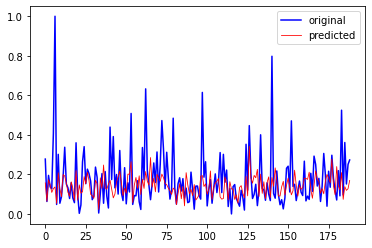

In [93]:
# Se grafican originales y estimados

x_ax = range(len(ypred))
#plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, Y_data_test, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

A partir de Acá es el procedimiento para estimar los valores provenientes de la carpeta Desafio_Contenido_C7_Total_10-2021_07-2022-a estimar.csv

In [94]:
# Se levantan los datos de las carpetas correspondientes

var_ind_2022 = pd.read_csv('/content/drive/MyDrive/ejercicios_proyectos/ancap/DATACHALLENGE 2022/Desafio_VariablesControl_DCH2022.csv', sep=';')

para_estimar_C7 = pd.read_csv('/content/drive/MyDrive/ejercicios_proyectos/ancap/DATACHALLENGE 2022/para_estimar/Desafio_Contenido_C7_Total_10-2021_07-2022-a estimar.csv')


In [95]:
# modificación de tipo de dato

var_ind_2022['TimeStamp'] = pd.to_datetime(var_ind_2022['TimeStamp'])

In [96]:
# creación de columna Fecha-hora

para_estimar_C7

para_estimar_C7['Fecha_Hora'] = pd.to_datetime(para_estimar_C7['Fecha'] + ' ' + para_estimar_C7['Hora'])
print(para_estimar_C7.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha       116 non-null    object        
 1   Hora        116 non-null    object        
 2   Fecha_Hora  116 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 2.8+ KB
None


In [97]:
# eliminación de nan

para_estimar_C7.dropna(inplace=True)
var_ind_2022.dropna(inplace=True)

In [98]:
# creación de dataframe con matrices de las últimas 6horas, explicado arriba, ver celda número 66 y texto anterior a esa celda.

var_ind_2022['indice'] = np.arange(var_ind_2022.shape[0])

dfXinterval_clean = []

for i in range(len(para_estimar_C7)):
    mask = var_ind_2022['TimeStamp'] == para_estimar_C7.iloc[i,2]
    ind = var_ind_2022.loc[mask]['indice']
    matriz_vars_tiempo = pd.DataFrame()
    for j in range(360):
        #print("indice>" +str(ind))
        #print("j>"+str(j))
        fila = var_ind_2022.iloc[ind-j,1:-1]
        #print(fila)
        matriz_vars_tiempo = matriz_vars_tiempo.append(fila, ignore_index = True)
    dfXinterval_clean.append(matriz_vars_tiempo)

In [99]:
# Creación de lista con valores de las medianas de las 6h anteriores, explicado anteriormente ver celdas númeross 66 y 67 y texto previo.

list_indep = []

for i in range(len(para_estimar_C7)):
    mediana = dfXinterval_clean[i].describe().iloc[5,].values
    list_indep.append(mediana)


In [100]:
# transformación de lista en dataframe

indep = pd.DataFrame(list_indep)

In [101]:
# Escalamiento de datos

X_scaler = MinMaxScaler()
X_data_estimar = X_scaler.fit_transform(indep)


In [102]:
# Cálculo de predichos

ypred = model.predict(X_data_estimar)

4/4 [==============================] - 0s 3ms/step


In [103]:
# Desescalado de predichos para obtener los valores en las escalas originales

ypred_desescalado = XY_scaler.inverse_transform(ypred)


In [104]:
# transformación en dataframe

df_ypred_desescalado = pd.DataFrame(ypred_desescalado)
df_ypred_desescalado

,0
0,1.355134
1,1.558610
2,1.118798
3,0.866552
4,1.499306
...,...
111,1.257719
112,1.351523
113,1.368361
114,1.507167


In [105]:
# generación de dataframe con las fechas pertenecientes al archivo 'Desafio_Contenido_C7_Total_10-2021_07-2022-a estimar.csv'

ypred_desescalado_fecha = pd.concat([para_estimar_C7, df_ypred_desescalado], axis=1)

In [106]:
# dataframe final, fechas y valores predichos.

ypred_desescalado_fecha = ypred_desescalado_fecha.rename(columns={0:'C7_estimado'})
ypred_desescalado_fecha

,Fecha,Hora,Fecha_Hora,C7_estimado
0,2021-10-01,07:02:00,2021-10-01 07:02:00,1.355134
1,2021-10-04,07:01:00,2021-10-04 07:01:00,1.558610
2,2021-10-05,07:01:00,2021-10-05 07:01:00,1.118798
3,2021-10-08,07:00:00,2021-10-08 07:00:00,0.866552
4,2021-10-12,07:01:00,2021-10-12 07:01:00,1.499306
...,...,...,...,...
111,2022-07-19,07:01:00,2022-07-19 07:01:00,1.257719
112,2022-07-22,07:02:00,2022-07-22 07:02:00,1.351523
113,2022-07-25,07:01:00,2022-07-25 07:01:00,1.368361
114,2022-07-26,07:01:00,2022-07-26 07:01:00,1.507167
